# Hash-randomiser scoping

## Background

### Issue description 

- Research deterministic (scope - permanent store) hashing methodology of `experiment key`, `unit_identifier` (& `timeframe`\ in switchback case) that we can apply. ([Kanban issue](https://justeattakeaway.atlassian.net/browse/TEX-1501))

- We currently use `np.random.choice` with a seed, which produces stable treatment assignments based on the position in an array, but not based on a unit identifiers.

- This is a problem if we re-randomise with a different pool of units (e.g. if we add additional units) because it doesn't guarantee that original units are re-allocated to the same treatment.

### Requirements of a good randomisation algorithm 

- Essential:

    1. Equal probability of seeing each treatment

    2. Consistent assignment on repeat assignements

    3. No correlation in assignment between overlapping experiments

- Desireable:

    4. Support of monotonic ramp-up so we can add new users without changing assignment of users already in the experiment

    5. Support of external control, so units can manually be allocated to certain assignments
    
- Based on [kohavi2009controlled](https://ai.stanford.edu/~ronnyk/2009controlledExperimentsOnTheWebSurvey.pdf)

### Common industry solutions

- There are two solutions that are generally considered (see [kohavi2009controlled](https://ai.stanford.edu/~ronnyk/2009controlledExperimentsOnTheWebSurvey.pdf) for a good discussion of pros and cons of the two approaches):
    
    1. A pseudorandom number generator with caching
    
    2. A (suitable) hash algorithm with partitioning 

- Most companies seem to rely on option 2, which is much simpler to implement ([mojito](https://mojito.mx/docs/example-hash-function-split-test-assignment), [kohavi2009controlled](https://ai.stanford.edu/~ronnyk/2009controlledExperimentsOnTheWebSurvey.pdf))

- The main benefit of hashing over caching is that we don't have to keep track of assignments by storing them in a table and possibly sharing them accross applications, but can generate and regenerate assignments efficiently and cheaply.

- The process works as follows:

    1. Create a unique id string (e.g. concatenate unit_key and experiment_key)
    
    2. Use that unique id as input to a "suitable" hash function to generate a hash value
    
    3. Allocate unit to treatment based on that hash value (i.e. for a simple two-variant experiment, split the range of possible hash-values into two segments [min, mid), [mid, max], then allocate units to treatment according to what segment hash value falls into)
    

- For a hash algorithm to be "suitable", it needs to have properties that guarantee at least the first three requirements of a good randomisation algorithm from above:

    1. Produce hash values that are uniformly distributed on a fixed interval (for property 1)
    
    2. Be deterministic, so that the same input always returns the same hash value (for properties 2 and 4)
     
    3. Be platform independent, so that it returns the same hash value for a given string on all platforms (for properties 2 and 4)
    
    4. Return a value that differs significantly and in unpredictable ways for a small change in the input string ([avalanche effect](https://en.wikipedia.org/wiki/Avalanche_effect), for property 3) 

- A few different such algorithms are used in practice

    - [kohavi2007practical (Microsoft)](https://ai.stanford.edu/~ronnyk/2007GuideControlledExperiments.pdf) suggest using MD5 hash function, pointing out that many other algorithms fail to meet one of the four requirements (often 3).
    
    - JET FM also uses MD5 ([code](https://github.je-labs.com/experimentation-platform/FeatureManagement_Portal/blob/26d745f072d67df6ca494a7c0584bac07040d9bf/src/JET.FeatureManagement.Client/Evaluation/IdHashVariantSelector.cs#L29), [docs](https://github.je-labs.com/experimentation-platform/documentation/blob/master/specifications/feature-management-config/FeatureConfig.md)).
    
    - [optimizely](https://docs.developers.optimizely.com/full-stack/docs/how-bucketing-works) uses MurmurHash.
    
    - [This article](https://medium.com/@thisisflea/a-good-hash-is-hard-to-find-6edbbf6a78b0) also suggests using MurmurHash.
    

## `matching-toolbox` implementation

### Requirements for randomisation algorithm

We need all 5 of the above requirements of a good randomisation algorithm:

1. Equal probability of seeing each treatment

2. Consistent assignment on repeat assignements

3. No correlation in assignment between overlapping experiments

4. Support of monotonic ramp-up so we can add new users without changing assignment of users already in the experiment

5. Support of external control, so units can manually be allocated to certain assignments

Additional requirements given our use-cases and workflow:

6. Support for multi-treatment experiments

7. Support for user-supplied allocation shares

8. Support for generation of multiple allocations to select the best (most balanced) one

### Use cases we need to support

Assignment mechanisms:

- Bernoulli trials / completely randomised expriments

- Stratified randomised experiments

- Switchback experiments

Scenarios:

- Plain-vanilla

- Monotonic ramp-up

- Manual control


Overview:

| Assignment mechanism / scenario   | Plain-vanilla | Monotonic ramp-up  | Manual control |
| ---        |    ----   |          --- | --- |
| **Completely randomised**      |        |   |   |
| **Stratified**   |        |      |   |
| **Switchback - deterministic**   |         |      |   |
| **Switchback - rerandomised**   |         |       |   |

(Note: We can think of the number of variants and corrensponding allocation shares as a third dimension, but if we implement the allocation function such that it is agnostic to the number of variants and allocation shares, then we don't need to worry about that.)

### Completely randomised experiments

#### Plain vanilla

- If we choose a hash-algorithm that meets the above requirements, we can do the following:

    - Partition the range of possible hash values into as many segments as there are variants, with the length of each segment proportional to the desired allocation share (either equal or user supplied) of the corresponding variant.
    
    - For each unit, concatenate `experiment_key`, `unit_identifier`, and `random_seed` to create a `hash_key` (we might need other elements such as "culture" in the key, but these can easily be added)
    
    - Feed the `hash_key` into the hashing algorithm to get a hash value
    
    - Allocate the unit to a variant based on what segment of the possible hash-value range the hash value falls into 


- This meets all our requirements because:
    
    1. Equal p for each treatment - hash values are distributed uniformly across the range of possible values

    2. Stable assignments across re-randomisations - hash values will be the same for a given `hash_key`

    3. Uncorrelated assignments across experiments - a different experiment id will create an unpredictable change in the hash value

    4. Support for monotonic ramp-up - the `hash_key`, and thus the hash value, and thus the treatment allocation, are independent of other units in the experiment

    5. Support for manual control - not handled by hashing, but as done presently by adding an additional "diagnostic" check when selecting valid candidate allocations

    6. Support for multi-treatment experiments - can partition range of hash values into as many segments as there are variants

    7. Support for user-supplied allocation shares - can create segments with lengths proportional to allocation shares

    8. Support for generation of multiple allocations to select the best (most balanced) one - adding seed to `hash_key` allows for generation of different allocations and ensures we can reproduce any one of them (if we have the seed).
    
- Below shows a proof-of concept implementation using Google's `farmhash.fingerprint64` algorithm.


In [3]:
import farmhash
from typing import List, Optional

import numpy as np
import pandas as pd
import seaborn as sns

In [244]:
n = 10000
cov_df = pd.DataFrame({
    "experiment_key": ["ex-123"] * n,
    "restaurant_key": [f'JE:UK:{i}' for i in range(n)],
    "country": ["country:1"] * int(0.7 * n) + ["country:2"] * int(0.25 * n) + ["country:3"] * int(0.05 * n)
    })

cov_df.head()

,experiment_key,restaurant_key,country
0,ex-123,JE:UK:0,country:1
1,ex-123,JE:UK:1,country:1
2,ex-123,JE:UK:2,country:1
3,ex-123,JE:UK:3,country:1
4,ex-123,JE:UK:4,country:1


In [245]:
# Note: commented out and added lines as needed to use class independently of rest of toolbox

COL_ASSIGNMENTS = "assignments"


class RandomiserHashed:
 
    # def __init__(self, *, cov_df: pd.DataFrame, random_seed: int, **kwargs):
    #     self.random_seed = random_seed
    #     super().__init__(df=cov_df, **kwargs)
    
    # Implementation details to discuss
    # - Pass seed to Randomiser or compute method? Latter would allow for single instantiation of class when generating multiple assignments
    # 

    def __init__(
        self,
        *,
        df: pd.DataFrame,
        random_seed: int,
        unit_identifier: str,
        variant_names: List[str],
        **kwargs
    ):
        self.df = df
        self.random_seed = random_seed
        self.unit_identifier = unit_identifier
        self.variant_names = variant_names


    def _custom_split_checks(self, split):
        """
        Performs basic sense-checks for user supplied split.
        """
        assert len(split) == len(self.variant_names), "Requires one probability per variant."
        assert sum(split) == 1, "Probabilities need to sum to 1."
        

    def _compute_assignments(
        self,
        *,
        split: List[float] = None,
        random_seed: int = 2312
    ) -> pd.Series:
        """
        Compute stable treatmend assignments.
        
        Partitions range or possible hash-values [0, 2**64] into segments -- one
        for each variant -- of lengths proportional to the split provided or of
        equal lenght if no split is provided. Unit-level hash values are then
        mapped to corresponding variant.
        """
        hash_key = self.df.experiment_key + self.df[self.unit_identifier] + str(random_seed)
        hash_values = hash_key.map(farmhash.hash64)
        
        if split:
            self._custom_split_checks(split)
            cum_split = np.array([0, *split]).cumsum()
        else:
            num_variants = len(self.variant_names)
            cum_split = np.linspace(0, 1, num_variants + 1)
        max_hash_value = 2**64
        bins = cum_split * max_hash_value
        
        assignments = pd.cut(hash_values, bins, labels=self.variant_names)
        return assignments
    

    def _compute_ass_df(self, *, split: List[float] = None) -> pd.DataFrame:
        """
        Return assignment DataFrame.
        """
        assignments = self._compute_assignments(split=split, random_seed=self.random_seed)
        
        ass_df = pd.DataFrame()
        ass_df[self.unit_identifier] = self.df[self.unit_identifier]
        ass_df["country"] = self.df.country         # added for demo
        ass_df[COL_ASSIGNMENTS] = assignments
        # ass_df[COL_IS_TREATED] = self._get_is_treated_values(assignments)
        # ass_df[COL_ASSIGNMENTS_FREQ] = 1
        return ass_df
    

split = [1/2, 1/4, 1/4]
rand_hashed = RandomiserHashed(df=cov_df, variant_names=['c', 't1', 't2'], unit_identifier='restaurant_key', random_seed=2312)
ass = rand_hashed._compute_ass_df(split=split)
ass.head()

,restaurant_key,country,assignments
0,JE:UK:0,country:1,t2
1,JE:UK:1,country:1,t1
2,JE:UK:2,country:1,t2
3,JE:UK:3,country:1,c
4,JE:UK:4,country:1,c


Produce seeded candidate assignments to find good candidates and select most balanced assignment

In [246]:
def ass_table(ass_df):
    """Helper to tabulate treatment group allocation by country."""
    table = pd.crosstab(ass_df.assignments, ass_df.country, dropna=False, normalize="columns")
    print(table, end="\n\n")
    

candidates = {}
for random_seed in range(100, 103):
    rand_hashed = RandomiserHashed(df=cov_df, variant_names=['c', 't1', 't2'], unit_identifier='restaurant_key', random_seed=random_seed)
    ass = rand_hashed._compute_ass_df(split=split)
    candidates[random_seed] = ass
    print(f"Random seed: {random_seed}")
    ass_table(ass)

Random seed: 100
country      country:1  country:2  country:3
assignments                                 
c             0.504286     0.4944      0.532
t1            0.244286     0.2576      0.228
t2            0.251429     0.2480      0.240

Random seed: 101
country      country:1  country:2  country:3
assignments                                 
c             0.510857     0.4948      0.496
t1            0.245857     0.2584      0.234
t2            0.243286     0.2468      0.270

Random seed: 102
country      country:1  country:2  country:3
assignments                                 
c             0.508143     0.4948       0.52
t1            0.249857     0.2592       0.25
t2            0.242000     0.2460       0.23



Re-produce any desired assignment

In [247]:
random_seed = 102

rand_hashed = RandomiserHashed(df=cov_df, variant_names=['c', 't1', 't2'], unit_identifier='restaurant_key', random_seed=random_seed)
ass = rand_hashed._compute_ass_df(split=split)

pd.testing.assert_series_equal(candidates[random_seed].assignments, ass.assignments)

#### Monotonic ramp-up

- We decided to start by supporting only the simplest possible use case, where treatment units are chosen randomly and the treatment is rolled out monotonically over time. Importantly, this doesn't support manual control, which we might add later if there is a need for it.

- Two main decision to make here:
    
    - How precisely to implement
    
    - How to deal with Simpson's paradox

- To implement the above simple case, there are two broad approaches: "bottom-up" or "top-down" sampling, which differ, respectively, in whether we ensure that the initial or the final sample is perfectly balanced.

- Bottom up sampling would work as follows: 

    - Use plain-vanilla implementation to select best assignment for initial treatment group (e.g. 1% of units) and store `random_seed`
    
    - Add additional units to `cov_df` and rerandomised using the same seed.
    
    - This will guarantee that the original units are allocated to the same treatments as before.
    
    - However, there is no guarantee that the new allocation is nicely balanced across all metrics we care about.
    
    - Possible remedy: we could separately randomise new units, select most balanced assignment, and then add the best assignment of those units to the best assignment of the original units (i.e. concatenate dataframes). 
    
- Top down would work as follows:

    - Use plain vanilla implementation to select best assignment for eventual treatment group (e.g. 50% of units) and store random seed.
    
    - Select only 1% of units for initial treatment exposure, then ramp-up as needed.
    
    - Would have to think through how to implement this exactly, and which approach is better.
    
    
- Also, to avoid Simpson's Paradox, we should probably either discard the pre-ramp up period or appropriately reweigh period results.

#### Manual control

- To guarantee that certain units are allocated to pre-specified variants (e.g. large cities to control), we can simply add an appropriate condition to the eligibility checks, as we do presently

### Stratified experiments -- implementation suggestion


#### Plain-vanilla
- Stratified assignment is currently implemented as Bernoulli trials. Was this chosen over completely randomised approach deliberately? If not, then this should be changed to block-wise completely randomised experiments, since Bernoulli doesn't guarantee that a fixed proportion in each strata is allocated to the desired variants. Instead, it is no different from simple (unstratified) randomisation: each unit in each strata has the same fixed probability of being allocated to control and treatment as it would in simple randomisation. Thus imbalance can occur just as in simple randomisation.

- Hashing is fundamentally incompatible with stratified randomisation (if implemented as blocked completely randomised experiments), so we can't use it.

- What we could do instead is to not explicitly stratify at the randomisation stage but instead add check for it in eligibility checker when selecting good candidate assignments.

- This has the advantages that all filtering for good candidate assignments happens in a single place and, as a result, also simplifies the code.

- The cost is computational: compred to a block-wise completely randomised implementation (not to current one), we might have to produce "many" more assignments to find well balanced ones, as we don't constrain the set of possible assignments to those that are well balanced on the stratification variable. I suspect that this is not a limiting factor, though.

- Team agrees that computational penalty we pay for this is almost surely not prohibitive. So we'll go ahead and implement this way.

#### Monotonic ramp-up

- Same as for simple randomisation.

- However, for small strata sizes, balance of "updated" assignment might be poor (assume that in a two-variant experiment there are only 10 additional observations for some strata, then its quite possible that 8 of them get allocated to one variant and only 2 to the other).


#### Manual control

- Same as for simple randomisation

### Deterministic switchback experiments (currently supported)

#### Plain vanilla

- We randomise once and then "extrapolate" future allocations based on initial randomisation.
    
- Hence, randomisation is taken care of by simple random assignment case.


#### Monotonic ramp-up

- What is precise use-case? What are we doing at present?

- If we want to be able to start experiment, and then in period *t* add additional units while keeping original units on their original "allocation path", we can do the following:

    1. Find best allocation for original units, store `random_seed`, create "allocation path".
    
    2. In period *t*, add additional units, rerandomise with stored seed, create new allocation path for all units (with period 1 referring to same time point as in step 1.)
    3. Keep running the experiment, starting at time *t* (original units follow path as originally intended, new units skip time periods 1 to t-1 and start at t).

- Limitation is the same as in all ramp-up cases: cannot guarantee that updated allocation is well balanced.


#### Manual control
    
- Same as in case of simple randomisation

### Rerandomised switchback experiments

- What's advantage of rerandomising at every step compared to deterministic variant currently implemented?

- We could implement this by additionally add a period indicator to the `hash_id`. The period indicator could either be date/time independent (i.e. period 1, 2, 3, etc.) or (date-time based: i.e. 2022-02-01, 2022-02-02, etc.). To be able to replicate the experiment at a later point, I'd think we'd want the former.

## Implementation

### Questions to discuss

- What elements do we need in `hash_key` ("culture"? "platform"? ...). Talk to Ciaran and Rodrigo.


### Choice of hash algorithm

- JET FM uses MD5, I suspect becase it's recommended by [kohavi2007practical](https://ai.stanford.edu/~ronnyk/2007GuideControlledExperiments.pdf).

- However, MD5 is a cryptographic algorithm, which provides functionality we don't strictly need for our purpose here, which comes at the cost of speed.

- Google's `farmhash` algorithms, in particular `fingerprint64` provide -- as far as I can tell -- all the functionality we need at faster speed and are also a bit simpler to implement (see [here](https://abhinav.github.io/farmhash/FarmHash.html), [here](https://github.com/google/farmhash), and [here](https://36-750.github.io/methods/hashing/#modern-methods), Appendix below for additional details, and [here](https://github.com/veelion/python-farmhash) for Python implementation).

- Based on my own runtime checks, `farmhash.fingerpring64` is also more than twice as fast as `MD5`.

- I thus suspect that had `farmhash` been around when Kohavi and co-authors wrote their paper, they would have recommended it instead. (They are recommended by knowledgeable [people](https://36-750.github.io/methods/hashing/#modern-methods) now, though not specifically for the purpose of randomisation.)

- The choice will come down, I'd think, to a trade-off between being consistent across the company and speed/ease of implementation.

- Given that the difference in speed is probably not critical, I'd think that we'd want to prioritise consistency within the company and opt for MD5 (unless we can convince JET FM to switch to `farmhash`...)

`farmhash` vs `MD5` runtime comparison: `farmhash` is more than twice as fast.

In [248]:
import hashlib

import farmhash
import pandas as pd

n = 1000
df = pd.DataFrame({
    "experiment_key": ["ex-123"] * n,
    "unit_key": [f'unit-{i}' for i in range(n)],
    }).assign(hash_key=lambda df: df.experiment_key + df.unit_key)

df.head()

,experiment_key,unit_key,hash_key
0,ex-123,unit-0,ex-123unit-0
1,ex-123,unit-1,ex-123unit-1
2,ex-123,unit-2,ex-123unit-2
3,ex-123,unit-3,ex-123unit-3
4,ex-123,unit-4,ex-123unit-4


In [249]:
%%timeit
def get_hash_as_int_md5(value: str) -> int:
    return int(hashlib.md5(value.encode("ascii")).hexdigest(), 16)


df.hash_key.map(get_hash_as_int_md5)

614 µs ± 2.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [250]:
%%timeit

def get_hash_as_int_farmhash(value: str) -> int:
    return farmhash.fingerprint64(value)

df.hash_key.map(get_hash_as_int_farmhash)

259 µs ± 2.36 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Potentially useful code

[Source](https://github.je-labs.com/LogisticsIntegrations/lastmile/blob/7b7129d9562d24fc979315e7f3c34bf95c07b5e1/lambdas/lastmile/lambdas/utils.py#L181-L187)


In [ ]:
def get_hash_as_int(value: str) -> int:
    return int(hashlib.md5(value.encode("ascii")).hexdigest(), 16)


def is_hash_in_percentage(value: str, percentage: int) -> bool:
    hashed_value = get_hash_as_int(value)
    return percentage > 0 and hashed_value % (100 / percentage) == 0


## Appendix

### `farmhash.fingerprint64` details

#### Value range

- `farmhash.fingerprint64` converts the input string into a 64-bit unsigned integer. This means it can create 2^64 unique integer values, and because they are unsigned ingeters, they range from 0 to 2^64 - 1 (if it were signed, the values would range from -2^64/2 to 2^64/2 - 1).

- The smalles possible value, 0, occurs if all bits are 0, the larges possible one, 2^64 - 1, when all bits are 1, as demonstrated below.

In [8]:
min = int("0" * 64, base=2)
max = int("1" * 64, base=2)

assert min == 0
assert max == 2**64 - 1

print(f"Min is: {min:>{len(str(max))}}\nMax is: {max}")

Min is:                    0
Max is: 18446744073709551615


#### Independence between experiments

- [This](https://medium.com/@thisisflea/a-good-hash-is-hard-to-find-6edbbf6a78b0) article discusses pitfalls of violating requirement 3 above and uses MurmurHash to avoid the issue.
- Example above suggests that `farmhash.fingerprint64` hashes are independent across experiments and thus can also be used.

Create user-experiment hash ids for two different experiments

In [9]:
df = pd.DataFrame({
    "user_id": np.arange(1000).astype(str)
}).assign(
    hash_exp1=lambda df: ("exp1" + df.user_id).map(farmhash.fingerprint64),
    hash_exp2=lambda df: ("exp2" + df.user_id).map(farmhash.fingerprint64),
)

df.head(3)

,user_id,hash_exp1,hash_exp2
0,0,13736453803979705643,14404520758346736070
1,1,15871172722897488427,7400506916968380015
2,2,13223836611583849727,6517024538844281180


Check whether there is correlatio between the hashes across the two experiments

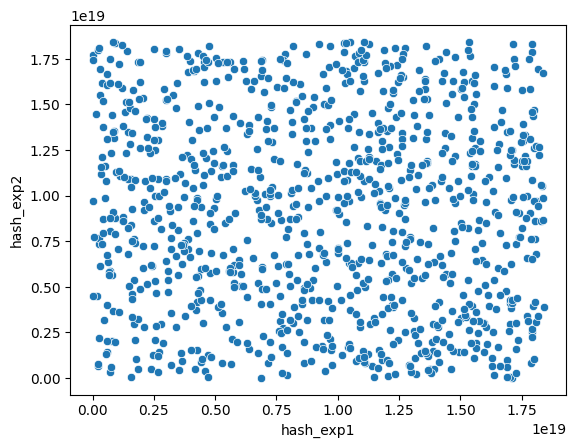

In [10]:
sns.scatterplot(x="hash_exp1", y="hash_exp2", data=df);

### Workflow for running non-standard experiments

1. Ingest and clean data

2. Create treatment assignment

    1. Generate *n* different assignments (using different seeds) and collect "good" candidate assignments based on diagnostic criteria
    
    2. Manually select best assignment out of candidate assignments
    
3. Pre-experiment tests (AA and power calculation)

4. Upload assignment to GBC

### Current randomiser

In [179]:
# Note: commented out and added lines as needed to use class independently of rest of toolbox

COL_ASSIGNMENTS = "assignments"


class Randomiser:
 
    # def __init__(self, *, cov_df: pd.DataFrame, random_seed: int, **kwargs):
    #     self.random_seed = random_seed
    #     super().__init__(df=cov_df, **kwargs)

    def __init__(
        self,
        *,
        df: pd.DataFrame,
        random_seed: int,
        unit_identifier: str,
        variant_names: List[str],
        **kwargs
        ):
        self.df = df
        self.random_seed = random_seed
        self.variant_names = variant_names
        self.unit_identifier = unit_identifier


    def _compute_ass_df(
        self, *, split: List[float] = None, stratify_by: Optional[str] = None
    ) -> pd.DataFrame:
        np.random.seed(self.random_seed)
        ass_df = pd.DataFrame()
        if stratify_by is not None:
            strata_dfs = [group for _, group in self.df.groupby(stratify_by)]
            df_strata_ordered = pd.concat(strata_dfs)
            ass_df[self.unit_identifier] = df_strata_ordered[self.unit_identifier]
            ass_df["country"] = df_strata_ordered.country         # added
            assignments = np.concatenate(
                [
                    np.random.choice(self.variant_names, size=len(stratum), p=split)
                    for stratum in strata_dfs
                ]
            )
        else:
            assignments = np.random.choice(
                self.variant_names, size=len(self.df), p=split
            )
            ass_df[self.unit_identifier] = self.df[self.unit_identifier]
            ass_df["country"] = self.df.country         # added


        ass_df[COL_ASSIGNMENTS] = assignments
        # ass_df[COL_IS_TREATED] = self._get_is_treated_values(assignments)
        # ass_df[COL_ASSIGNMENTS_FREQ] = 1

        return ass_df


rand = Randomiser(df=cov_df, random_seed=2312, variant_names=['c', 't1', 't2'], unit_identifier='restaurant_key')

Custom split, not stratified

In [180]:
split = [1/2, 1/4, 1/4]
ass = rand._compute_ass_df(split=split)
ass_table(ass)

country      country:1  country:2  country:3
assignments                                 
c             0.499429     0.5024      0.454
t1            0.254000     0.2360      0.286
t2            0.246571     0.2616      0.260



Custom split, stratified (note: stratifying doesn't guarantee balanced assignments)

In [181]:
ass = rand._compute_ass_df(split=split, stratify_by="country")
ass_table(ass)

country      country:1  country:2  country:3
assignments                                 
c             0.495857     0.5076      0.478
t1            0.250429     0.2504      0.264
t2            0.253714     0.2420      0.258

